In [1]:
import os
import sys , time , traceback  , itertools , ipdb
import datetime as dt
from pprint import pprint
from tqdm import tqdm
import warnings , ipdb
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl



import tsalib , common

In [8]:
plt.style.use('ggplot')

In [6]:
%matplotlib inline

In [4]:
date='2019-05-31'

ticker = 'INTU'
data = tsalib.get_data(date=date,ticker=ticker,data_source='web',horizon=22)
vix = tsalib.get_data(date=date,ticker='^VIX',data_source='web',horizon=22)

{'model': {'sim_id': '5c64958b-b918-47c0-95e0-308a88303281', 'ticker': 'INTU', 'arch_model': 'EGARCH', 'sim_prc': 0.1, 'method': 'simulation', 'dist': 'StudentsT', 'arch_params': (3, 3), 'mean_model': 'Constant', 'date': '2019-05-31', 'prev_month_vola': 9.67, 'expected_var_d': 11.67, 'real_vola': 0, 'predicted_range': array([237.36883767, 245.14201344, 253.03770174, 264.45022155])}, 'stats': {'null_rmse': 1.0, 'arch_sim_rmse': 1.0}}


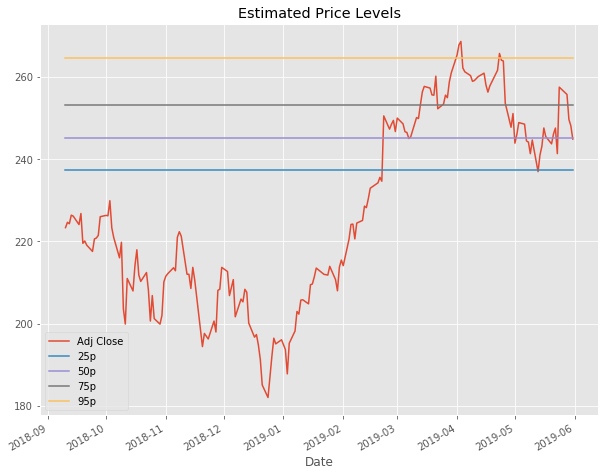

In [9]:
years = 10
month = 12

ticker=ticker
sim_prc=0.1
model='EGARCH'
arch_params=(3,3)
#mean_model='ARX'
#mean_model='HARX'
mean_model='Constant'

method='simulation'
#method= 'bootstrap'

dist='StudentsT'
#dist='normal'
#dist='skewt'

data_source='web'

res = tsalib.eval_model(TS=data
                  ,ticker=ticker
                  ,horizon=22
                  ,model=model
                  ,print_model=False
                  ,sim_prc=sim_prc
                  ,method=method
                  ,arch_params=arch_params
                  ,mean_model=mean_model
                  ,dist=dist
                 ,live=True)

print(res)

fig = plt.figure(figsize=(10,8))
vis_data = data.iloc[-182:].copy()
vis_data['25p'] = res['model']['predicted_range'][0]
vis_data['50p'] = res['model']['predicted_range'][1]
vis_data['75p'] = res['model']['predicted_range'][2]
vis_data['95p'] = res['model']['predicted_range'][3]
ax = vis_data[['Adj Close','25p','50p','75p','95p']].plot(title='Estimated Price Levels',ax=fig.gca())

In [156]:
def plot_vix_dist(year1=None,year2=None,agg_tails=False):
    if year2 is None:
        year2 = year1
    vixc = vix.assign(days=1).loc[f'{year1}-01-01':f'{year2}-12-31'].reset_index().drop(['Date'],axis=1)#['days']
    if agg_tails:
        pass
        #vixc[vixc.days>30,'days'] = vixc[vixc.days>30,'days'].sum()
    vixc['Adj Close'] =vixc['Adj Close'].round().astype(int)
    vixc = vixc[['Adj Close','days']]
    vixc_q = (vixc['Adj Close'].quantile([x /100 for x in range(0,100,5)])
              .reset_index()
              .drop_duplicates("Adj Close")
              .rename({'Adj Close':'Price Levels','index':'Percentile'},axis=1)
             )
    plt.figure(figsize=(10,8))
    agg_plot = vixc.groupby('Adj Close')['days'].sum()
    
    agg_plot.plot.bar()
    plt.ylabel('# of days')
    plt.title(year1+'-'+year2+' year')
    plt.show()
    return pd.merge(agg_plot.reset_index().rename({'Adj Close':'Price Levels'},axis=1),vixc_q,on='Price Levels',how='left').fillna(method='ffill')

In [157]:
vixc.loc[vixc['Adj Close']>30,'Adj Close'].sum()

106

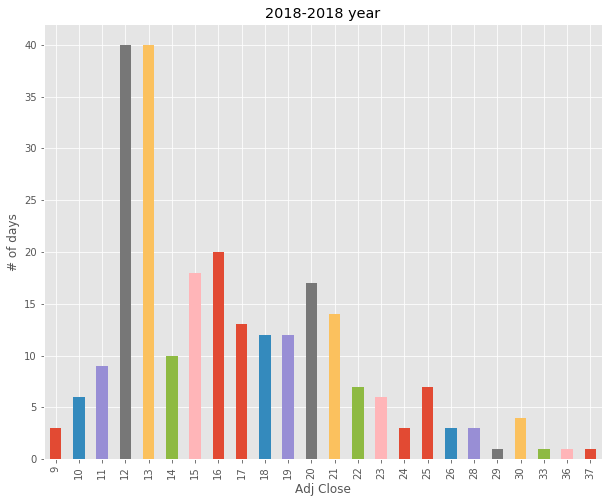

,Price Levels,days,Percentile
0,9,3,0.00
1,10,6,0.00
2,11,9,0.05
3,12,40,0.10
4,13,40,0.25
5,14,10,0.40
6,15,18,0.45
7,16,20,0.55
8,17,13,0.60
9,18,12,0.65


In [158]:
plot_vix_dist('2018')

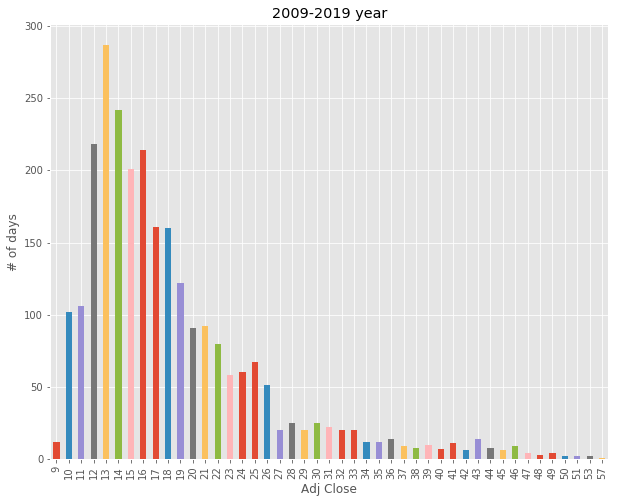

In [90]:
plot_vix_dist('2009','2019')

In [ ]:

res = tsalib.test_prediction(n_month_back=month*years
                      ,date=date
                      ,ticker=ticker
                      ,sim_prc=sim_prc
                      ,print_model=False
                      ,model=model
                      ,arch_params=arch_params
                      ,mean_model=mean_model
                      ,method=method
                      ,dist=dist
                      ,data_source=data_source
                      )
time.sleep(1)

sim_df = pd.DataFrame([res['by_month'][i]['model'] for i in range(len(res['by_month']))]).set_index('date')
sim_df.index = pd.to_datetime(sim_df.index)
comb_df = sim_df.join(vix,how='left')

print({'summary':[res['summary'],{'vix_corr':round(np.corrcoef(comb_df['expected_var_d'],comb_df['Adj Close'])[0,1],2)}]})

In [ ]:
sim_df.loc['2018-01-01':'2018-05-01']

In [ ]:
#plt.style.use('seaborn')
sim_df[['prev_month_vola','expected_var_d','real_vola']].plot(title=f'{model} Backtest'
                                                              ,colormap='Paired'
                                                             )


In [ ]:
common.plot_multi(comb_df[['expected_var_d','Adj Close']],title='Simulated SPY Volatility vs VIX',loc='right', figsize=(10, 5))

In [ ]:
#Make a predictions
